In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

# Hyper-parameters
user_clip_num = 2 # Note: in our work this parameter is actually set to 3, which means 3-1 samples for each real user.
user_pos_num_clip = 2 # only split users with training positive interactions >= user_clip_num * user_pos_num_clip
max_interact_num = 10
like_threshold = 2

In [2]:
rootpath="../data/"
print("Loading big matrix...")
big_matrix = pd.read_csv(rootpath + "big_matrix.csv")

print("Loading small matrix...")
small_matrix = pd.read_csv(rootpath + "/small_matrix.csv")

# print("Loading social network...")
# social_network = pd.read_csv(rootpath + "/social_network.csv")
# social_network["friend_list"] = social_network["friend_list"].map(eval)

print("Loading item features...")
item_feat = pd.read_csv(rootpath + "/item_categories.csv")
item_feat["feat"] = item_feat["feat"].map(eval)

print("All data loaded.")

Loading big matrix...
Loading small matrix...
Loading item features...
All data loaded.


In [3]:
big_matrix.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3650,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9599,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5263,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1964,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8235,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


In [4]:
big_matrix.shape

(12530806, 8)

In [5]:
user_item_count={} #{0:{1:9,2:7}}
unwanted_interact = []
for i in tqdm(big_matrix.index):
    uID = big_matrix.loc[i,'user_id']
        
    if uID not in user_item_count:
        user_item_count[uID] = {}
        
    iID = big_matrix.loc[i,'video_id']
    
    if iID not in user_item_count[uID]:
        user_item_count[uID][iID] = 1
    else:
        user_item_count[uID][iID] += 1
    if user_item_count[uID][iID]>10:
        unwanted_interact.append(i)
        

100%|███████████████████████████████████████████████████████████████████| 12530806/12530806 [04:59<00:00, 41774.97it/s]


In [6]:
len(unwanted_interact)

42764

In [7]:
big_matrix = big_matrix.drop(unwanted_interact)

In [8]:
#big_matrix[(big_matrix.user_id == 0)&(big_matrix.video_id==1032)]

In [9]:
#big_matrix[(big_matrix.user_id==3586) & (big_matrix.watch_ratio>2)]

In [10]:
'''big_matrix[(big_matrix.user_id == 0)&(big_matrix.video_id==9919)]
big_matrix[(big_matrix.user_id == 1)]
len(set(big_matrix[big_matrix.user_id==1].video_id))
m = big_matrix[big_matrix.user_id == 0]#['video_id','timestamp','watch_ratio']
#s = set([])
f = 0
for i in range(m.shape[0]):
    #a = ''
    for j in list(m.loc[i,['video_id']]):
        if j == f:
            print(f)
        f = j
    #s.add(a)
'''

"big_matrix[(big_matrix.user_id == 0)&(big_matrix.video_id==9919)]\nbig_matrix[(big_matrix.user_id == 1)]\nlen(set(big_matrix[big_matrix.user_id==1].video_id))\nm = big_matrix[big_matrix.user_id == 0]#['video_id','timestamp','watch_ratio']\n#s = set([])\nf = 0\nfor i in range(m.shape[0]):\n    #a = ''\n    for j in list(m.loc[i,['video_id']]):\n        if j == f:\n            print(f)\n        f = j\n    #s.add(a)\n"

In [11]:
item_feat.head()

,video_id,feat
0,0,[8]
1,1,"[27, 9]"
2,2,[9]
3,3,[26]
4,4,[5]


In [12]:
# create folders
path='./features'
if not os.path.exists(path):
    os.mkdir(path)
path='./sets'
if not os.path.exists(path):
    os.mkdir(path)
    
# matrix preprocessing
big_matrix = big_matrix.dropna()
small_matrix = small_matrix.dropna()

# only keep watch_ratio>like_threshold as postive interactions
big_matrix_pos = big_matrix[big_matrix["watch_ratio"]>=like_threshold];
print("big_matrix_pos shape", big_matrix_pos.shape)

small_matrix_pos = small_matrix[small_matrix["watch_ratio"]>=like_threshold];
print("small_matrix_pos shape", small_matrix_pos.shape)

big_matrix_pos shape (931167, 8)
small_matrix_pos shape (209616, 8)


In [13]:
item_id_map = {}
user_id_map = {}
userID = 0
itemID = 0
big_pos_list = []
for i in tqdm(range(big_matrix_pos.shape[0])):
    if big_matrix_pos.iloc[i,0] in user_id_map:
        uID = user_id_map[big_matrix_pos.iloc[i,0]]
    else:
        uID = userID
        user_id_map[big_matrix_pos.iloc[i,0]] = uID
        userID += 1
        
    if big_matrix_pos.iloc[i,1] in item_id_map:
        iID = item_id_map[big_matrix_pos.iloc[i,1]]
    else:
        iID = itemID
        item_id_map[big_matrix_pos.iloc[i,1]] = iID
        itemID += 1
        
    big_pos_list.append([uID,iID])
    
small_pos_list = []
for i in tqdm(range(small_matrix_pos.shape[0])):
    if small_matrix_pos.iloc[i,0] in user_id_map:
        uID = user_id_map[small_matrix_pos.iloc[i,0]]
    else:
        continue
    if small_matrix_pos.iloc[i,1] in item_id_map:
        iID = item_id_map[small_matrix_pos.iloc[i,1]]
    else:
        continue 
    small_pos_list.append([uID,iID])

small_pos_dict = {}
for pair in small_pos_list:
    userID, itemID = pair
    if userID not in small_pos_dict:
        small_pos_dict[userID] = []
    small_pos_dict[userID].append(itemID)
big_pos_dict = {}
for pair in big_pos_list:
    userID, itemID = pair
    if userID not in big_pos_dict:
        big_pos_dict[userID] = []
    big_pos_dict[userID].append(itemID)

100%|████████████████████████████████████████████████████████████████████████| 209616/209616 [00:21<00:00, 9948.76it/s]


In [14]:
# added for splitting users: only split training data, keep testing data untouched.

user_all_dict = {} # to record every exposure interaction with time and watch_ratio
for i in tqdm(range(big_matrix.shape[0])):
    if big_matrix.iloc[i,0] in user_id_map:
        uID = user_id_map[big_matrix.iloc[i,0]]
        
        # this is a recorded positive interaction
        if big_matrix.iloc[i,7]>=like_threshold: 
            iID = item_id_map[big_matrix.iloc[i,1]]
#             assert [uID, iID] in big_pos_list # double check this is recorded
            
            if uID not in user_all_dict:
                user_all_dict[uID] = {'exposure':[], 'like':[]}
            user_all_dict[uID]['exposure'].append([iID, big_matrix.iloc[i,6], big_matrix.iloc[i,7]])
            user_all_dict[uID]['like'].append([iID, big_matrix.iloc[i,6], big_matrix.iloc[i,7]])
            
        # this is a negative interaction
        else:
            if big_matrix.iloc[i,1] in item_id_map: 
                iID = item_id_map[big_matrix.iloc[i,1]]
            # this is a new item unmapped
            else: 
                iID = len(item_id_map)
                item_id_map[big_matrix.iloc[i,1]] = iID
                
            if uID not in user_all_dict:
                user_all_dict[uID] = {'exposure':[], 'like':[]}
            user_all_dict[uID]['exposure'].append([iID, big_matrix.iloc[i,6], big_matrix.iloc[i,7]])
    else:
        continue # this user is deleted in previous MF data



100%|████████████████████████████████████████████████████████████████████| 12488042/12488042 [36:32<00:00, 5696.37it/s]


In [15]:
big_pos_dict0 = big_pos_dict

In [16]:
# np.save('./sets/user_all_dict.npy', np.array(user_all_dict))

In [17]:
def takeSecond(ele):
    return ele[1]

# user_all_dict = np.load('./sets/user_all_dict.npy', allow_pickle=True).item()
# rank the interaction history, actually already ranked
for uID in tqdm(user_all_dict):
    user_all_dict[uID]['exposure'].sort(key=takeSecond)
    user_all_dict[uID]['like'].sort(key=takeSecond)

100%|████████████████████████████████████████████████████████████████████████████| 7175/7175 [00:01<00:00, 5570.27it/s]


# add cluster part

In [18]:
embed_item = np.load("./embed_item_MF_kuai_256factor_num_0.0001lr_256bs_4ng.npy")
# embed_item = np.load("./embed_item/embed_user_IPS_kuai_256factor_num_0.0001lr_1024IPS.npy")

In [19]:
embed_item.shape

(10608, 256)

In [20]:
item_feature_dict_ori = {}
i_f_dict = dict(item_feat.feat)
for i in i_f_dict:
    if i in item_id_map:
        item_feature_dict_ori[item_id_map[i]] = i_f_dict[i]

# create category_list file
category_list_ori = []
category_id_ori = {}
for item in item_feature_dict_ori:
    for cat in item_feature_dict_ori[item]:
        if cat not in category_list_ori:
            category_list_ori.append(cat)
            category_id_ori[cat] = cat

In [21]:
category_map_dict = {}
cate_embed = np.zeros([len(category_list_ori), embed_item.shape[1]])
category_count_dict = {}
for i in range(embed_item.shape[0]):
    for c in item_feature_dict_ori[i]:
        if c not in category_count_dict:
            category_count_dict[c] = 1/len(item_feature_dict_ori[i])
        else:
            category_count_dict[c] += 1/len(item_feature_dict_ori[i])
        cate_embed[c] += embed_item[i]

for c in category_count_dict:
    cate_embed[c] /= category_count_dict[c]


In [22]:
import pandas as pd  
from sklearn.cluster import KMeans  
import matplotlib.pyplot as plt  
'利用SSE选择k'  
SSE = []  # 存放每次结果的误差平方和  
for k in tqdm(range(1,32)):  
    estimator = KMeans(n_clusters=k, random_state=1)  # 构造聚类器  
    estimator.fit(cate_embed)  
    SSE.append(estimator.inertia_)  

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]D:\download\anaconda\envs\myjupyter\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
  3%|██▋                                                                                | 1/31 [00:00<00:12,  2.33it/s]D:\download\anaconda\envs\myjupyter\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
  6%|█████▎                                                                             | 2/31 [00:00<00:10,  2.72it/s]D:\download\anaconda\envs\myjupyter\lib\site-

 65%|████████████████████████████████████████████████████▉                             | 20/31 [00:07<00:03,  2.76it/s]D:\download\anaconda\envs\myjupyter\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
 68%|███████████████████████████████████████████████████████▌                          | 21/31 [00:07<00:03,  2.75it/s]D:\download\anaconda\envs\myjupyter\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
 71%|██████████████████████████████████████████████████████████▏                       | 22/31 [00:07<00:03,  2.73it/s]D:\download\anaconda\envs\myjupyter\lib\site-

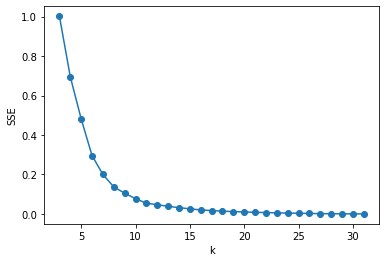

In [23]:
X = range(1,32) 
plt.xlabel('k')  
plt.ylabel('SSE')  
plt.plot(X[2:],SSE[2:],'o-')  
plt.show() 

In [24]:
from sklearn.cluster import KMeans
category_num_new = 5
kmeans_model = KMeans(category_num_new, random_state=1)
kmeans_model.fit(cate_embed)
labels = kmeans_model.labels_
print(kmeans_model.labels_)
print(kmeans_model.inertia_)


D:\download\anaconda\envs\myjupyter\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 0 3 1 3 1 2 4 1 2 3 1 3 1 4 1 2 1 3 1 3 0 0 0 1 4 0 2 2 1]
0.48183331640969995


In [25]:
for i in set(labels):
    print(i, sum(labels==i))

0 6
1 11
2 5
3 6
4 3


In [26]:
# create item_feature_dict file CHANGED!!!
item_feature_dict = {}
for item in range(len(item_feature_dict_ori)):
    item_feature_dict[item]=[]
    for i in range(len(item_feature_dict_ori[item])):
        if labels[item_feature_dict_ori[item][i]] not in item_feature_dict[item]:
            item_feature_dict[item].append(labels[item_feature_dict_ori[item][i]])

np.save('./features/item_feature_dict.npy', np.array(item_feature_dict))

# create category_list file
category_list = list(range(category_num_new))
category_id = {}
for c in range(category_num_new):
    category_id[c] = c

np.save('./features/category_id.npy', np.array(category_id))
np.save('./features/category_list.npy', np.array(category_list))

In [27]:
# take care: whether exposed but unliked items introduce new categories.
print(category_list)

[0, 1, 2, 3, 4]


In [28]:
# split users and generate new big_pos_dict and big_pos_list.

# a function to calc T given exposure items and item_category_dict&category_list
def calc_T(t_seq, item_category, category_list):
    cate_dis = [0] * (max(category_list)+1)
    for item in t_seq:
        for c in item_category[item]:
            cate_dis[c] += 1/len(item_category[item])
    cate_dis = [c/len(t_seq) for c in cate_dis]
    return cate_dis

# a function to calc Y given exposure items, liked items, and item_category_dict&category_list
def calc_Y(t_seq, next_d, item_category, category_list):
    exposure_dis = [0]* (max(category_list)+1)
    like_dis = [0]* (max(category_list)+1)
    for item in t_seq:
        for c in item_category[item]:
            exposure_dis[c] += 1/len(item_category[item])
    for item in next_d:
        for c in item_category[item]:
            like_dis[c] += 1/len(item_category[item])
    ctr_dis = [like_dis[c]/exposure_dis[c] if exposure_dis[c] > 0 else 0 for c in range(len(exposure_dis))]
    return ctr_dis
    
subuser_all_dict = {} # subuserID
user_subuser_map = {}
user_subuser_exp_dict = {} # save exposure data of users and subusers
user_num = len(user_id_map)
assert user_num not in big_pos_dict

for uID in tqdm(user_all_dict):
    pos_num = len(user_all_dict[uID]['like'])
    
    # save exposure data of uID
    user_subuser_exp_dict[uID] = [entry[0] for entry in user_all_dict[uID]['exposure']]
    
    # only split users with postive len > user_clip_num * user_pos_num_clip
    if pos_num < user_clip_num * user_pos_num_clip:
        continue
    pos_num_clip = pos_num//user_clip_num
    for i in range(user_clip_num-1):
        
        subuser_id = user_num
        user_num += 1
        user_subuser_map[subuser_id] = uID
        subuser_all_dict[subuser_id] = {}
        
        # find like history in current clip
        d = user_all_dict[uID]['like'][:(i+1)*pos_num_clip]
        
        # find treatment in next clip
        st = user_all_dict[uID]['exposure'].index(user_all_dict[uID]['like'][(i+1)*pos_num_clip])
        if i != user_clip_num-2: # not last clip
            ed = user_all_dict[uID]['exposure'].index(user_all_dict[uID]['like'][(i+2)*pos_num_clip])
            t_seq = user_all_dict[uID]['exposure'][st:ed]
        else:
            t_seq = user_all_dict[uID]['exposure'][st:]
            
        # find like history in next clip
        if i != user_clip_num-2: # not last clip
            next_d = user_all_dict[uID]['like'][(i+1)*pos_num_clip:(i+2)*pos_num_clip]
        else:
            next_d = user_all_dict[uID]['like'][(i+1)*pos_num_clip:]
        
        # save exposure data of subuser_id: find the last liked item and save its exposure.
        exposure_index = user_all_dict[uID]['exposure'].index(d[-1])
        user_subuser_exp_dict[subuser_id] = user_all_dict[uID]['exposure'][:exposure_index+1]
        
        d = [entry[0] for entry in d]
        next_d = [entry[0] for entry in next_d]
        t_seq = [entry[0] for entry in t_seq]
        
        T = calc_T(t_seq, item_feature_dict, category_list)
        Y = calc_Y(t_seq, next_d, item_feature_dict, category_list)

        subuser_all_dict[subuser_id]['D'] = d
        subuser_all_dict[subuser_id]['T'] = T
        subuser_all_dict[subuser_id]['Y'] = Y
                
        # update big_pos_dict and big_pos_list
        for item in d:
            if subuser_id not in big_pos_dict:
                big_pos_dict[subuser_id] = []
            big_pos_dict[subuser_id].append(item)
            big_pos_list.append([subuser_id, item])

        if uID == 0:
            print(subuser_all_dict[subuser_id])
        

  0%|                                                                                         | 0/7175 [00:00<?, ?it/s]

{'D': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 24, 83, 84, 85, 86, 6, 87, 88, 38, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 33, 101, 102, 103, 104, 1, 105, 106, 107, 108, 109, 110, 111, 112, 59, 113, 114, 115, 116, 117, 118, 119, 119, 120, 120, 40, 40, 121, 121, 122, 122, 123, 123, 124, 124, 125, 125, 126, 126, 127, 127, 128], 'T': [0.016615930999492642, 0.29109589041095885, 0.358701166920345, 0.13368848300355152, 0.199898528665652], 'Y': [0.0, 0.07320261437908498, 0.15275813295615276, 0.12523719165085387, 0.09137055837563449]}


100%|█████████████████████████████████████████████████████████████████████████████| 7175/7175 [00:09<00:00, 747.42it/s]


In [29]:
# np.save('./features/user_subuser_exp_dict.npy', np.array(user_subuser_exp_dict))
np.save('./features/user_subuser_map.npy', np.array(user_subuser_map))
np.save('./features/subuser_info.npy', np.array(subuser_all_dict))

np.save('./features/item_id_map.npy', np.array(item_id_map))
np.save('./features/user_id_map.npy', np.array(user_id_map))

np.save('./sets/big_pos_list.npy', np.array(big_pos_list))
np.save('./sets/small_pos_list.npy', np.array(small_pos_list))

np.save('./sets/big_pos_dict.npy', np.array(big_pos_dict))
np.save('./sets/small_pos_dict.npy', np.array(small_pos_dict))

In [30]:
# double check the dataset
for u in small_pos_dict:
    if len(small_pos_dict[u])<2:
        print(u)

for u in small_pos_dict:
    if u not in big_pos_dict:
        print(u)

In [31]:
training_list = big_pos_list
validation_list = []
testing_list = []

training_dict = big_pos_dict
validation_dict = {}
testing_dict = {}

for userID in small_pos_dict:
    items = small_pos_dict[userID]
    if len(items) < 2:
        print(userID)
        continue
    if userID not in big_pos_dict:
        continue
    item_num_for_test = max(int(len(items)*0.5), 1)
    test_items = items[-item_num_for_test:]
    items = items[:-item_num_for_test]
    valid_items = items
    
    validation_list += [[userID, itemID] for itemID in list(valid_items)]
    testing_list += [[userID, itemID] for itemID in list(test_items)]
    validation_dict[userID] = valid_items
    testing_dict[userID] = test_items
    
np.save('./sets/training_list.npy', np.array(big_pos_list))
np.save('./sets/validation_list.npy', np.array(validation_list))
np.save('./sets/testing_list.npy', np.array(testing_list))

np.save('./sets/training_dict.npy', np.array(training_dict))
np.save('./sets/validation_dict.npy', np.array(validation_dict))
np.save('./sets/testing_dict.npy', np.array(testing_dict))

In [32]:
'''t_d = np.load('../kuai-v1/sets/training_dict.npy',allow_pickle=True).item()
t_l = np.load('../kuai-v1/sets/training_list.npy')
v_d = np.load('../kuai-v1/sets/validation_dict.npy',allow_pickle=True).item()
v_l = np.load('../kuai-v1/sets/validation_list.npy')
te_d = np.load('../kuai-v1/sets/testing_dict.npy',allow_pickle=True).item()
te_l = np.load('../kuai-v1/sets/testing_list.npy')
print(len(validation_list),len(v_l),len(testing_list),len(te_l))
max_u_num = 7174
for u in t_d:
    if t_d[u] != training_dict[u]:
        print(u)
short_list = []
for pair in big_pos_list:
    u,i = pair
    if u<=max_u_num:
        short_list.append(pair)
print(len(short_list), len(t_l))
print(short_list == t_l)#identical'''

"t_d = np.load('../kuai-v1/sets/training_dict.npy',allow_pickle=True).item()\nt_l = np.load('../kuai-v1/sets/training_list.npy')\nv_d = np.load('../kuai-v1/sets/validation_dict.npy',allow_pickle=True).item()\nv_l = np.load('../kuai-v1/sets/validation_list.npy')\nte_d = np.load('../kuai-v1/sets/testing_dict.npy',allow_pickle=True).item()\nte_l = np.load('../kuai-v1/sets/testing_list.npy')\nprint(len(validation_list),len(v_l),len(testing_list),len(te_l))\nmax_u_num = 7174\nfor u in t_d:\n    if t_d[u] != training_dict[u]:\n        print(u)\nshort_list = []\nfor pair in big_pos_list:\n    u,i = pair\n    if u<=max_u_num:\n        short_list.append(pair)\nprint(len(short_list), len(t_l))\nprint(short_list == t_l)#identical"

In [33]:
pop_rank = dict(big_matrix_pos['video_id'].value_counts())# original ID 7116 occurs only in small matrix
for i in item_id_map:
    if i not in pop_rank:
        print(i)
        pop_rank[i] = 0
pop_rank_maped = {}
for i in pop_rank:
    if i in item_id_map:
        pop_rank_maped[item_id_map[i]] = pop_rank[i]
item_rank_dict = {} #id:rank
rank = 0
for element in pop_rank_maped:
    item_rank_dict[element] = rank
    rank += 1
np.save('./features/item_rank_dict.npy', np.array(item_rank_dict))

8646
7469
9004
5510
2185
4616
8267
6923
5142
1703
6657
9600
1485
1418
8344
5036
7096
6724
7860
7511
7171
10325
10472
7649
5386
4424
4782
3303
52
7067
7625
9012
6543
7846
6021
7005
10670
10712
5053
9725
3195
6079
6137
10576
7622
6217
10209
7464
8917
3330
7544
10602
9242
9637
4857
1062
7796
2794
9590
2588
9484
10611
7958
7819
7116
1835
1658
7550
2137
9767
9468
3909
5110
3856
3045
9489
874
5272
205
8115
6666
5148
8099
9295
10076
1470
6131
6697
7895
1772
6981
3314
3509
8051
6941
1811
3753
1962
5159
6492
7783
5179
6162
6219
1758
9314
8176
9581
1796
4004
4881
4999
8862
1894
5127
4
9135
6306
7827
9471


In [34]:
CountAll = [0] * len(category_list)
for item in range(10611):
    CountAll[item_feature_dict[item][0]]+=pop_rank_maped[item]
CountAll

[7132, 233471, 332062, 184067, 174435]

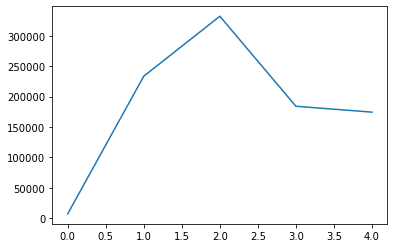

In [35]:
plt.plot(CountAll)
plt.show()

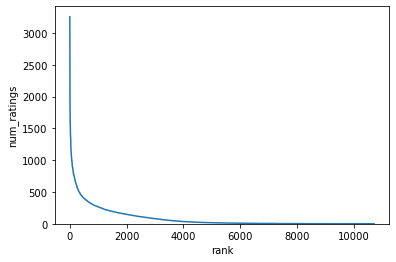

In [36]:
import matplotlib.pyplot as plt
a = list(pop_rank_maped.values())
plt.plot(a)
plt.ylim(bottom=0.)

plt.xlabel("rank")
plt.ylabel("num_ratings")
plt.show()

In [37]:
user_feature_file = {}
for userID in big_pos_dict:
    user_feature_file[userID] = [['U'+str(userID)]]
    #user_feature_file[userID][0] += ['UF'+feat for feat in user_feature[userID]]
    user_feature_file[userID].append([str(1)]*len(user_feature_file[userID][0]))
item_feature_file = {}
for itemID in tqdm(item_feature_dict):
    item_feature_file[itemID] = [['I'+str(itemID)]]
    item_feature_file[itemID].append(['1'])
    for cate in range(0, len(category_id)):
        if cate in item_feature_dict[itemID]:
            item_feature_file[itemID][0].append('IC'+str(cate))
            item_feature_file[itemID][1].append(str(round(1.0/len(item_feature_dict[itemID]), 2)))
        else:
            item_feature_file[itemID][0].append('IC'+str(cate))
            item_feature_file[itemID][1].append(str(0))

np.save('./features/user_feature_file.npy', np.array(user_feature_file))
np.save('./features/item_feature_file.npy', np.array(item_feature_file))

100%|█████████████████████████████████████████████████████████████████████████| 10728/10728 [00:00<00:00, 87213.49it/s]


In [38]:
category_num = len(category_list)
topk_category = 3
user_fml_cat_big = {}
for user in big_pos_dict:
    category_cnt = [0] * category_num
    for item in big_pos_dict[user]:
        for cat in item_feature_dict[item]:
            category_cnt[cat] += 1
    sorted_list = list(np.argsort(category_cnt))
    fml_cat = sorted_list[-topk_category:]
    user_fml_cat_big[user] = fml_cat
np.save('./features/user_fml_cat.npy', np.array(user_fml_cat_big))

In [39]:
item_cat_vec = {}
for itemID in item_feature_dict:
    item_cat_vec[itemID] = [0] * category_num
    cat_num = len(item_feature_dict[itemID])
    for cat in item_feature_dict[itemID]:
        item_cat_vec[itemID][cat] = 1 / np.sqrt(cat_num)
np.save('./features/item_cat_vec.npy', np.array(item_cat_vec))